In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchinfo import summary

from model import Model, NormalizationMethod
from trainer import Trainer
from tester import Tester
from utils import visualize_data, show_misclassified_images
from dataloader import Cifar10DataLoader

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
print("Is CUDA available? ", use_cuda)

Is CUDA available?  True


In [4]:
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2470, 0.2435, 0.2616),
        ),
        transforms.Resize((32, 32), antialias=False),  # type: ignore
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(10),
        # transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        # transforms.RandomCrop(32, padding=4),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2470, 0.2435, 0.2616),
        ),
        transforms.Resize((32, 32), antialias=False),  # type: ignore
    ]
)

In [5]:
cifar10 = Cifar10DataLoader(is_cuda_available=use_cuda)

train_loader = cifar10.get_loader(transforms=train_transforms, train=True)
test_loader = cifar10.get_loader(transforms=train_transforms, train=False)

Files already downloaded and verified
Files already downloaded and verified


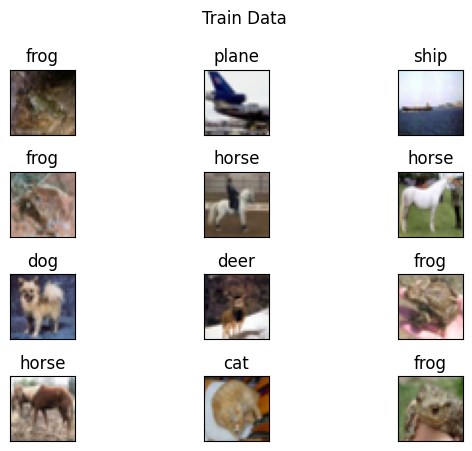

In [6]:
visualize_data(train_loader, 12, "Train Data", classes=cifar10.classes)

In [7]:
model = Model(norm_method=NormalizationMethod.GROUP).to(device)
batch_size = 2
summary(
    model,
    input_size=(batch_size, 3, 32, 32),
    depth=4,
    col_width=18,
    col_names=[
        "kernel_size",
        "input_size",
        "output_size",
        "num_params",
        "trainable",
    ],
    row_settings=["var_names"],
)

Layer (type (var_name))                  Kernel Shape       Input Shape        Output Shape       Param #            Trainable
Model (Model)                            --                 [2, 3, 32, 32]     [2, 10]            --                 True
├─Sequential (conv_block1)               --                 [2, 3, 32, 32]     [2, 32, 32, 32]    --                 True
│    └─ConvLayer (0)                     --                 [2, 3, 32, 32]     [2, 16, 32, 32]    --                 True
│    │    └─Sequential (layer)           --                 [2, 3, 32, 32]     [2, 16, 32, 32]    --                 True
│    │    │    └─Conv2d (0)              [3, 3]             [2, 3, 32, 32]     [2, 16, 32, 32]    432                True
│    │    │    └─GroupNorm (1)           --                 [2, 16, 32, 32]    [2, 16, 32, 32]    32                 True
│    │    │    └─ReLU (2)                --                 [2, 16, 32, 32]    [2, 16, 32, 32]    --                 --
│    │    │    └─Drop

In [8]:
model = Model(norm_method=NormalizationMethod.GROUP).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)
criterion = nn.NLLLoss()


trainer = Trainer(model, train_loader, optimizer, criterion, device)
tester = Tester(model, test_loader, criterion, device)

for epoch in range(1, 21):
    trainer.train(epoch=epoch)
    tester.test()
    scheduler.step()

EPOCH = 1 | LR = 0.01 | Loss = 2.05 | Batch = 390 | Accuracy = 19.70: 100%|██████████| 391/391 [00:09<00:00, 40.04it/s]


Test set: Average loss: 0.0145, Accuracy: 2782/10000 (27.82%)


EPOCH = 2 | LR = 0.01 | Loss = 1.43 | Batch = 390 | Accuracy = 36.26: 100%|██████████| 391/391 [00:09<00:00, 39.61it/s]


Test set: Average loss: 0.0120, Accuracy: 4267/10000 (42.67%)


EPOCH = 3 | LR = 0.01 | Loss = 1.30 | Batch = 390 | Accuracy = 46.03: 100%|██████████| 391/391 [00:09<00:00, 40.49it/s]


Test set: Average loss: 0.0121, Accuracy: 4209/10000 (42.09%)


EPOCH = 4 | LR = 0.01 | Loss = 1.09 | Batch = 390 | Accuracy = 53.15: 100%|██████████| 391/391 [00:09<00:00, 40.38it/s]


Test set: Average loss: 0.0095, Accuracy: 5717/10000 (57.17%)


EPOCH = 5 | LR = 0.01 | Loss = 0.91 | Batch = 390 | Accuracy = 57.02: 100%|██████████| 391/391 [00:09<00:00, 41.01it/s]


Test set: Average loss: 0.0097, Accuracy: 5484/10000 (54.84%)


EPOCH = 6 | LR = 0.01 | Loss = 1.36 | Batch = 390 | Accuracy = 59.53: 100%|██████████| 391/391 [00:10<00:00, 38.46it/s]


Test set: Average loss: 0.0097, Accuracy: 5584/10000 (55.84%)


EPOCH = 7 | LR = 0.01 | Loss = 0.87 | Batch = 390 | Accuracy = 61.82: 100%|██████████| 391/391 [00:10<00:00, 38.80it/s]


Test set: Average loss: 0.0083, Accuracy: 6264/10000 (62.64%)


EPOCH = 8 | LR = 0.01 | Loss = 0.95 | Batch = 390 | Accuracy = 63.39: 100%|██████████| 391/391 [00:09<00:00, 39.13it/s]


Test set: Average loss: 0.0078, Accuracy: 6433/10000 (64.33%)


EPOCH = 9 | LR = 0.01 | Loss = 0.94 | Batch = 390 | Accuracy = 64.40: 100%|██████████| 391/391 [00:09<00:00, 39.67it/s]


Test set: Average loss: 0.0076, Accuracy: 6517/10000 (65.17%)


EPOCH = 10 | LR = 0.01 | Loss = 0.80 | Batch = 390 | Accuracy = 65.50: 100%|██████████| 391/391 [00:10<00:00, 37.72it/s]


Test set: Average loss: 0.0071, Accuracy: 6790/10000 (67.90%)


EPOCH = 11 | LR = 0.001 | Loss = 0.97 | Batch = 390 | Accuracy = 69.46: 100%|██████████| 391/391 [00:09<00:00, 39.95it/s]


Test set: Average loss: 0.0067, Accuracy: 6936/10000 (69.36%)


EPOCH = 12 | LR = 0.001 | Loss = 0.93 | Batch = 390 | Accuracy = 70.18: 100%|██████████| 391/391 [00:09<00:00, 39.39it/s]


Test set: Average loss: 0.0067, Accuracy: 6950/10000 (69.50%)


EPOCH = 13 | LR = 0.001 | Loss = 0.81 | Batch = 390 | Accuracy = 70.53: 100%|██████████| 391/391 [00:09<00:00, 40.48it/s]


Test set: Average loss: 0.0067, Accuracy: 6997/10000 (69.97%)


EPOCH = 14 | LR = 0.001 | Loss = 1.00 | Batch = 390 | Accuracy = 70.42: 100%|██████████| 391/391 [00:10<00:00, 38.35it/s]


Test set: Average loss: 0.0068, Accuracy: 6962/10000 (69.62%)


EPOCH = 15 | LR = 0.001 | Loss = 0.85 | Batch = 390 | Accuracy = 70.69: 100%|██████████| 391/391 [00:09<00:00, 40.13it/s]


Test set: Average loss: 0.0067, Accuracy: 6987/10000 (69.87%)


EPOCH = 16 | LR = 0.001 | Loss = 0.97 | Batch = 390 | Accuracy = 70.97: 100%|██████████| 391/391 [00:10<00:00, 38.30it/s]


Test set: Average loss: 0.0066, Accuracy: 7041/10000 (70.41%)


EPOCH = 17 | LR = 0.001 | Loss = 0.64 | Batch = 390 | Accuracy = 71.11: 100%|██████████| 391/391 [00:09<00:00, 40.14it/s]


Test set: Average loss: 0.0065, Accuracy: 7002/10000 (70.02%)


EPOCH = 18 | LR = 0.001 | Loss = 0.82 | Batch = 390 | Accuracy = 71.37: 100%|██████████| 391/391 [00:09<00:00, 40.02it/s]


Test set: Average loss: 0.0067, Accuracy: 6979/10000 (69.79%)


EPOCH = 19 | LR = 0.001 | Loss = 0.74 | Batch = 390 | Accuracy = 71.29: 100%|██████████| 391/391 [00:09<00:00, 40.28it/s]


Test set: Average loss: 0.0065, Accuracy: 7094/10000 (70.94%)


EPOCH = 20 | LR = 0.001 | Loss = 0.81 | Batch = 390 | Accuracy = 71.50: 100%|██████████| 391/391 [00:09<00:00, 40.17it/s]


Test set: Average loss: 0.0065, Accuracy: 7065/10000 (70.65%)


In [9]:
misclassified_images, predictions, labels = tester.get_misclassified_images()

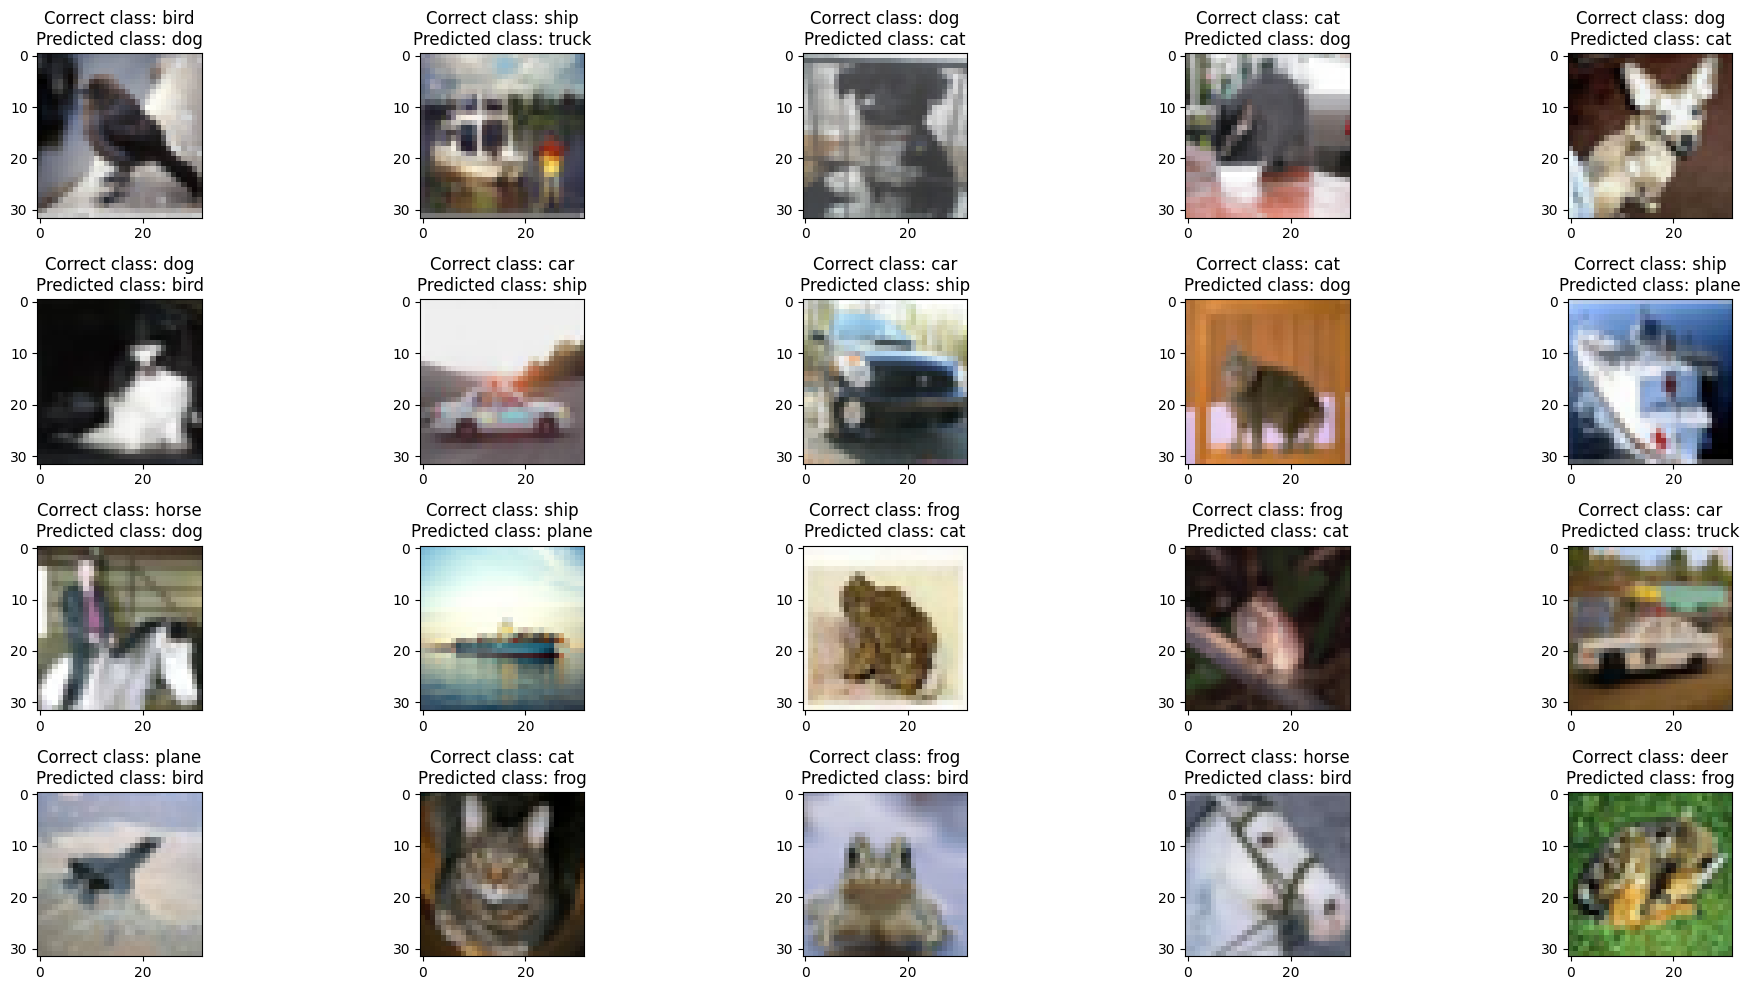

In [10]:
show_misclassified_images(
    misclassified_images[:20],
    predictions[:20],
    labels[:20],
    cifar10.classes,
)